# Wine quality

In [8]:
import os
import warnings
import sys

#from wine import parameters

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import mlflow
import mlflow.sklearn

import logging

In [9]:
# Read the wine-quality csv file from the URL, change this to postgres database later

def load_data():
    "loadc data in csv format from url"

    logger = logging.getLogger(__name__)

    csv_url =\
        'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(csv_url, sep=';')
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)

    return data


In [10]:
df_wine = load_data()

In [11]:
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


only for plotting in notebook

In [5]:
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## 1. Getting familiar with data

### 1.1 Missing Values

In [6]:
print(df_wine.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


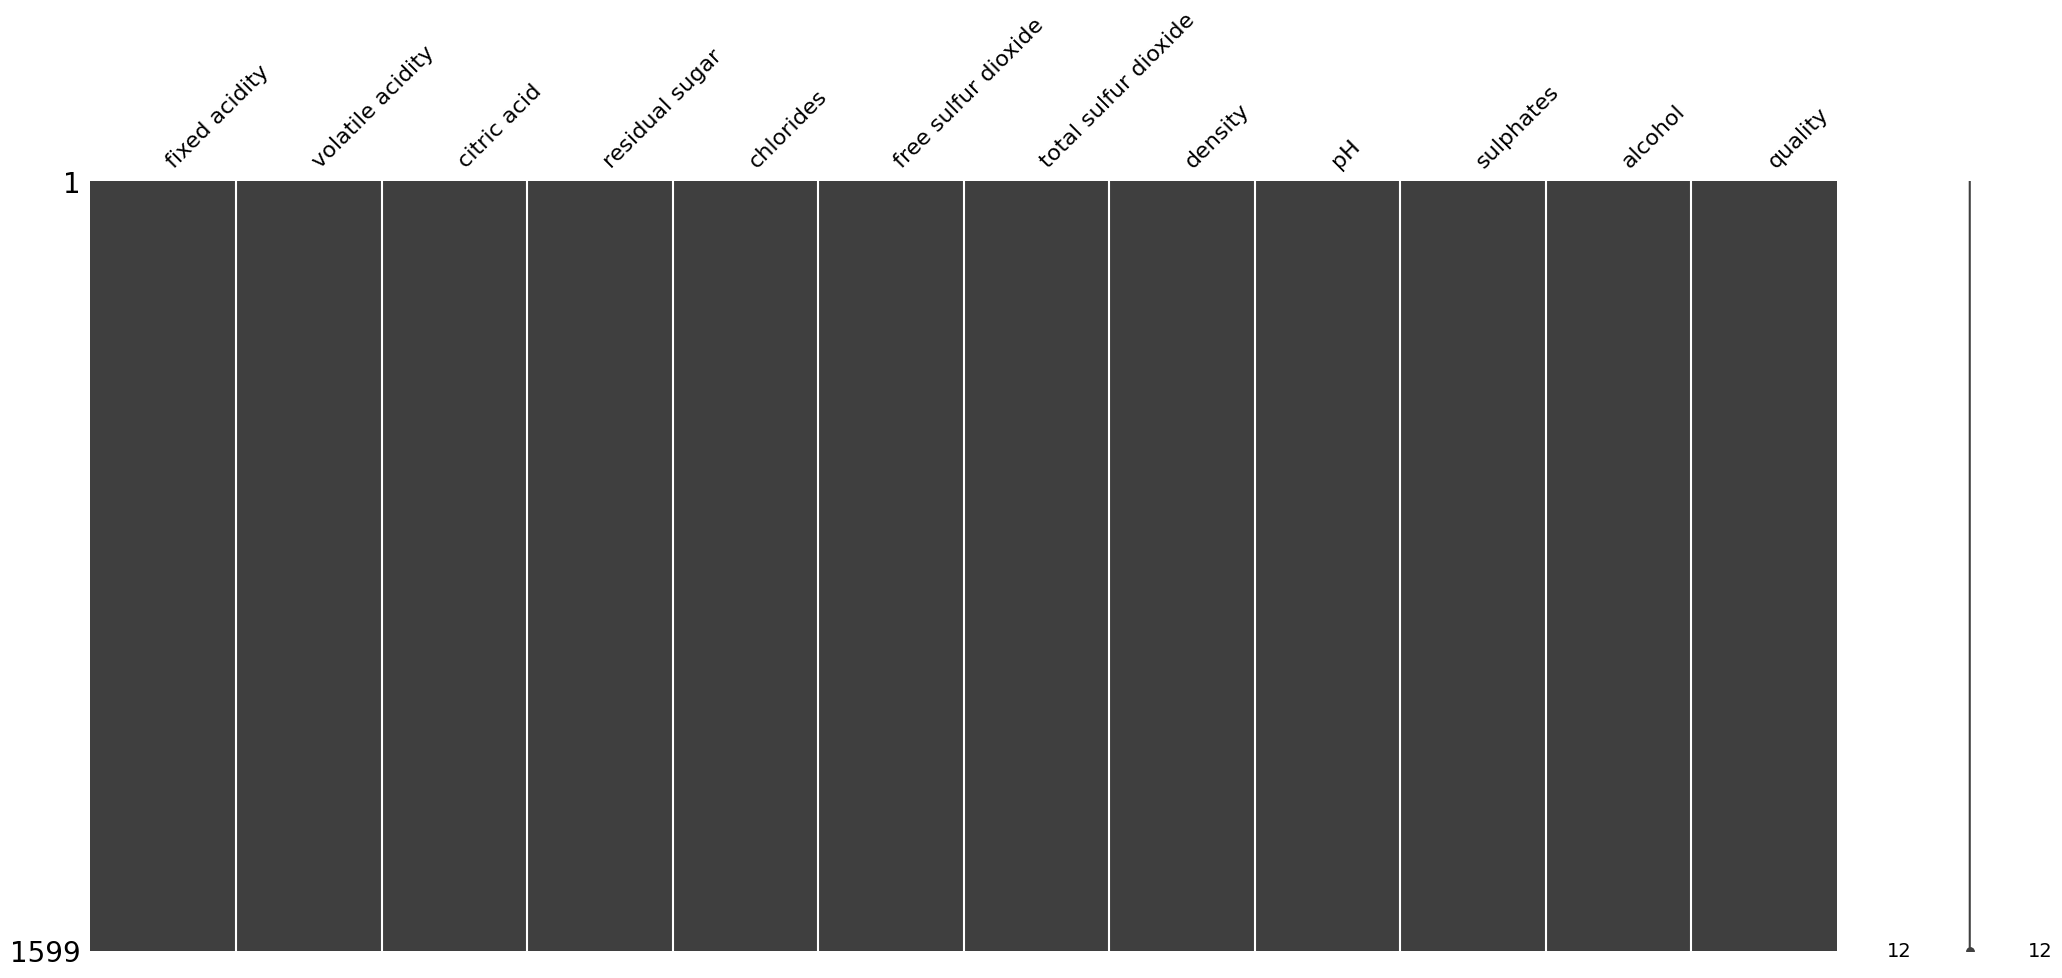

In [7]:
# Visualize the general missing values of data
msno.matrix(df_wine)
plt.show()

In [8]:
df_wine.groupby(["quality"]).mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,8.360000,0.884500,0.171000,2.635000,0.122500,11.000000,24.900000,0.997464,3.398000,0.570000,9.955000
4,7.779245,0.693962,0.174151,2.694340,0.090679,12.264151,36.245283,0.996542,3.381509,0.596415,10.265094
5,8.167254,0.577041,0.243686,2.528855,0.092736,16.983847,56.513950,0.997104,3.304949,0.620969,9.899706
6,8.347179,0.497484,0.273824,2.477194,0.084956,15.711599,40.869906,0.996615,3.318072,0.675329,10.629519
7,8.872362,0.403920,0.375176,2.720603,0.076588,14.045226,35.020101,0.996104,3.290754,0.741256,11.465913
8,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444


In [9]:
df_wine.sort_values(by = "quality")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1478,7.1,0.875,0.05,5.7,0.082,3.0,14.0,0.99808,3.40,0.52,10.2,3
832,10.4,0.440,0.42,1.5,0.145,34.0,48.0,0.99832,3.38,0.86,9.9,3
899,8.3,1.020,0.02,3.4,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,3
1374,6.8,0.815,0.00,1.2,0.267,16.0,29.0,0.99471,3.32,0.51,9.8,3
459,11.6,0.580,0.66,2.2,0.074,10.0,47.0,1.00080,3.25,0.57,9.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
495,10.7,0.350,0.53,2.6,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
1403,7.2,0.330,0.33,1.7,0.061,3.0,13.0,0.99600,3.23,1.10,10.0,8
1090,10.0,0.260,0.54,1.9,0.083,42.0,74.0,0.99451,2.98,0.63,11.8,8
1449,7.2,0.380,0.31,2.0,0.056,15.0,29.0,0.99472,3.23,0.76,11.3,8


In [10]:
df_wine.groupby(["quality"]).size()

quality
3     10
4     53
5    681
6    638
7    199
8     18
dtype: int64

see the distribution of the quality variable. I wanted to make sure that I had enough ‘good quality’ wines in my dataset 

(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

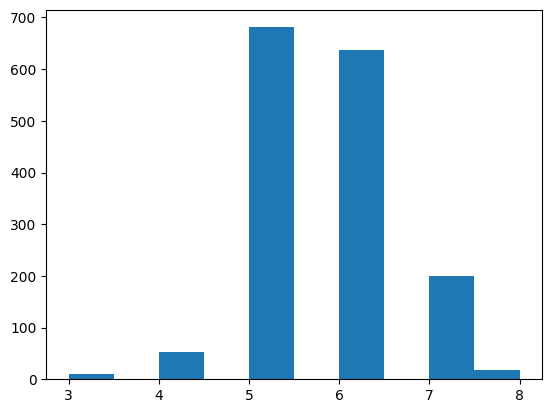

In [13]:
plt.hist(df_wine["quality"])

<AxesSubplot: >

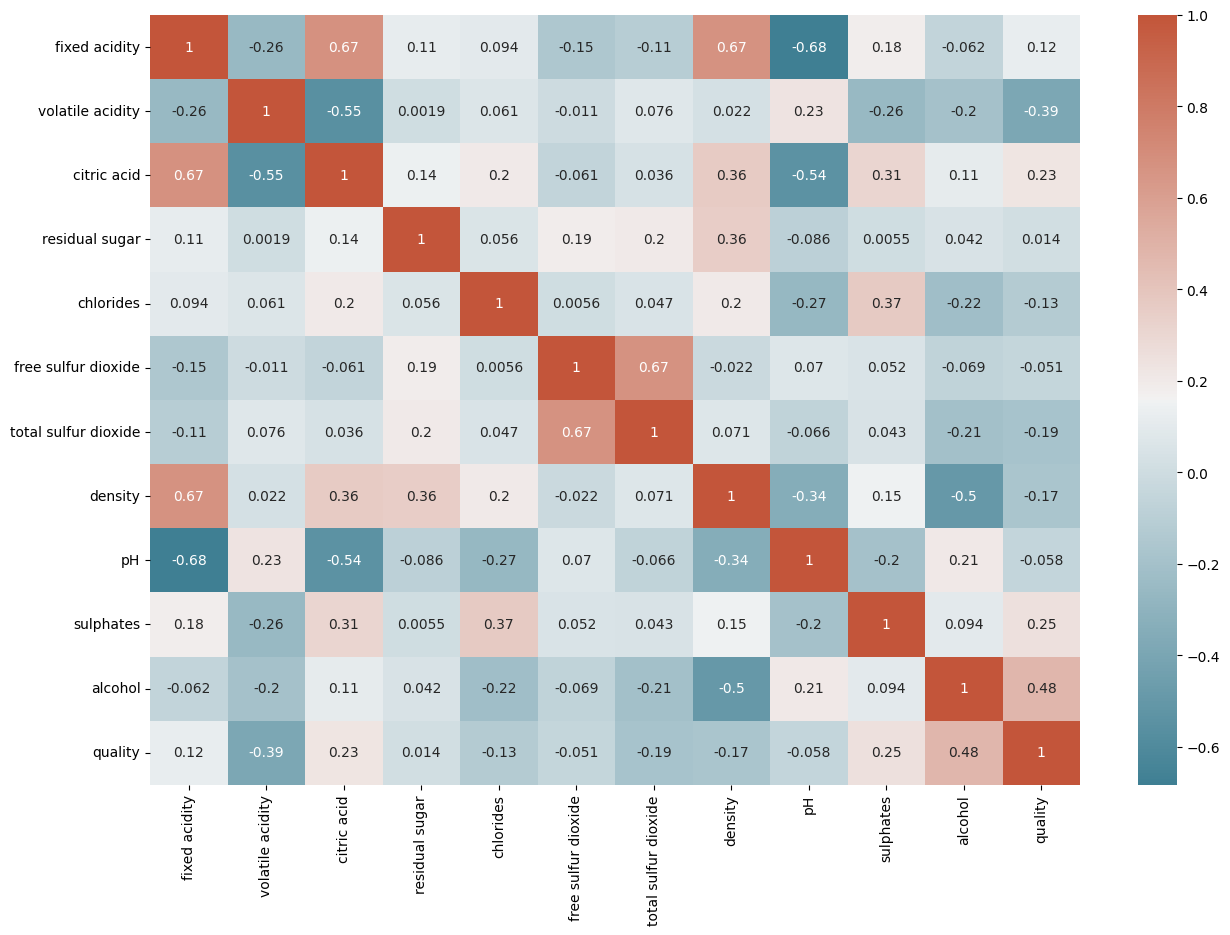

In [14]:
corr = df_wine.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### 1.2 Convert to a Classification Problem

#### A first trial by plotting a classification model using the raw data results in quite bad accuracy, here we perform feature engineer by classifying quality
#### quality >= 7 as good
#### quality < 7 as bad

In [15]:
df_wine["goodquality"] = [1 if x >=7 else 0 for x in df_wine["quality"]]

# Separate feature variables and target variable
X = df_wine.drop(['quality','goodquality'], axis = 1)
y = df_wine['goodquality']


Standardizing Feature Variable

In [16]:
# Normalize feature variables
from sklearn.preprocessing import StandardScaler
X_features = X
X = StandardScaler().fit_transform(X)

In [12]:
# Create Classification version of target variable
df_wine['goodquality'] = [1 if x >= 7 else 0 for x in df_wine['quality']]
# Separate feature variables and target variable
X = df_wine.drop(['quality','goodquality'], axis = 1)
y = df_wine['goodquality']

In [46]:
# Splitting the data
#from sklearn.model_selection import train_test_split
#train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.25, random_state=0)

# 2. Modelling

Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=1)
model2.fit(train_x, train_y)
y_pred2 = model2.predict(test_x)
print(classification_report(test_y, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       355
           1       0.68      0.58      0.63        45

    accuracy                           0.92       400
   macro avg       0.82      0.77      0.79       400
weighted avg       0.92      0.92      0.92       400



In [25]:
#import modules
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# define and configure the model
model = RandomForestClassifier()

# evaluate the model 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report model performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.912 (0.022)


In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV 


In [23]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

2.1 randome forest, cv = 5

In [40]:
rf = RandomForestClassifier(random_state = 1)

PARAM_GRID =  {'n_estimators': [50,450],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [25],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [2],
                                  'min_samples_split': [2]}
                                  
clf_rf = GridSearchCV(rf, param_grid = PARAM_GRID, cv = 5, verbose = True, n_jobs = -1, scoring='f1')
best_clf_rf = clf_rf.fit(X,y)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Random Forest
Best Score: 0.34951473536380107
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


2.2 random forest, repeatedStratifiedKFold

In [41]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rf = RandomForestClassifier(random_state = 1)

PARAM_GRID =  {'n_estimators': [50,450],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [25],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [2],
                                  'min_samples_split': [2]}
                                  
clf_rf = GridSearchCV(rf, param_grid = PARAM_GRID, cv = cv, verbose = True, n_jobs = -1, scoring='f1')
best_clf_rf = clf_rf.fit(X,y)
clf_performance(best_clf_rf,'Random Forest')

Fitting 30 folds for each of 4 candidates, totalling 120 fits
Random Forest
Best Score: 0.5989046502909093
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 450}


2.3 Use smote to get around imbalanced dataset

In [30]:
from imblearn.over_sampling import SMOTE, ADASYN
#import sklearn
X_smote, Y_smote = SMOTE(random_state=42).fit_resample(X, y)  #Beware, this takes some time based on the dataset size
#X_adasyn, Y_adasyn = ADASYN().fit_resample(X_train, y_train)


In [43]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rf = RandomForestClassifier(random_state = 1)

PARAM_GRID =  {'n_estimators': [50, 450],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [25],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [2],
                                  'min_samples_split': [2]}
                            
clf_rf = GridSearchCV(rf, param_grid = PARAM_GRID, cv = cv, verbose = True, n_jobs=-1, scoring='f1')
best_clf_rf = clf_rf.fit(X_smote,Y_smote)
clf_performance(best_clf_rf,'Random Forest')

Fitting 30 folds for each of 4 candidates, totalling 120 fits
Random Forest
Best Score: 0.9413757597282859
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 450}


Looks like smote did a great job in compensating imbalanced dataset. From now on we will use smote dataset for future models

3.1 xgboost

In [57]:
from xgboost import XGBClassifier


In [60]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

xgb = XGBClassifier(random_state=1)


PARAM_GRID = {
        'min_child_weight': [1, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5],
        'n_estimators': [50, 450]
        }

clf_rf = GridSearchCV(xgb, param_grid=PARAM_GRID, cv=cv,
                      verbose=True, n_jobs=-1, scoring='f1')
best_clf_rf = clf_rf.fit(X_smote, Y_smote)
clf_performance(best_clf_rf, 'xgboost')


Fitting 30 folds for each of 160 candidates, totalling 4800 fits
xgboost
Best Score: 0.9503817364001808
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 450, 'subsample': 0.6}


Well done! XGboost!

In [79]:
import xgboost as xgb
model5 = xgb.XGBClassifier(random_state=1)
model5.fit(train_x, train_y)
y_pred5 = model5.predict(test_x)
print(classification_report(test_y, y_pred5))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       355
           1       0.62      0.69      0.65        45

    accuracy                           0.92       400
   macro avg       0.79      0.82      0.80       400
weighted avg       0.92      0.92      0.92       400



### pycaret

In [13]:
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,goodquality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


In [ ]:
from pycaret.classification import *

In [17]:
pycaret

NameError: name 'pycaret' is not defined

In [15]:

s = setup(data=df_wine, target='goodquality', silent=True)


NameError: name 'setup' is not defined